<font size='6'><b>E-commerce analytics</b></font><br><br>
<font size='4'>Antonio Buzzelli</font><br>
<font size='4'>March 2023</font>

Dataset: https://www.kaggle.com/datasets/gabrielramos87/an-online-shop-business?sort=published


In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


# Data


In [2]:
df = pd.read_csv('sales.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 536350 entries, 0 to 536349
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   TransactionNo  536350 non-null  object 
 1   Date           536350 non-null  object 
 2   ProductNo      536350 non-null  object 
 3   ProductName    536350 non-null  object 
 4   Price          536350 non-null  float64
 5   Quantity       536350 non-null  int64  
 6   CustomerNo     536295 non-null  float64
 7   Country        536350 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 32.7+ MB


In [3]:
df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country
0,581482,12/9/2019,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom
1,581475,12/9/2019,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom
2,581475,12/9/2019,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom
3,581475,12/9/2019,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom
4,581475,12/9/2019,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom
...,...,...,...,...,...,...,...,...
536345,C536548,12/1/2018,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany
536346,C536548,12/1/2018,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany
536347,C536548,12/1/2018,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany
536348,C536548,12/1/2018,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany


* TransactionNo (categorical): a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
* Date (numeric): the date when each transaction was generated.
* ProductNo (categorical): a five or six-digit unique character used to identify a specific product.
* Product (categorical): product/item name.
* Price (numeric): the price of each product per unit in pound sterling (£).
* Quantity (numeric): the quantity of each product per transaction. Negative values related to cancelled transactions.
* CustomerNo (categorical): a five-digit unique number that defines each customer.
* Country (categorical): name of the country where the customer resides.

In [4]:
df['Date'] = pd.to_datetime(df['Date'])
df[['ProductNo', 'CustomerNo']] = df[['ProductNo', 'CustomerNo']].astype('object')
# Creating a `TotalPrice` colum
df['TotalPrice'] = df['Quantity'] * df['Price']
# Creating another `TotalPrice` column that takes into consideration returns (represented by -n values in the `Quantity` column).
df['TotalPriceN'] = np.where(df['TotalPrice'] < 0, 0, df['TotalPrice'])

In [5]:
df

,TransactionNo,Date,ProductNo,ProductName,Price,Quantity,CustomerNo,Country,TotalPrice,TotalPriceN
0,581482,2019-12-09,22485,Set Of 2 Wooden Market Crates,21.47,12,17490.0,United Kingdom,257.64,257.64
1,581475,2019-12-09,22596,Christmas Star Wish List Chalkboard,10.65,36,13069.0,United Kingdom,383.40,383.40
2,581475,2019-12-09,23235,Storage Tin Vintage Leaf,11.53,12,13069.0,United Kingdom,138.36,138.36
3,581475,2019-12-09,23272,Tree T-Light Holder Willie Winkie,10.65,12,13069.0,United Kingdom,127.80,127.80
4,581475,2019-12-09,23239,Set Of 4 Knick Knack Tins Poppies,11.94,6,13069.0,United Kingdom,71.64,71.64
...,...,...,...,...,...,...,...,...,...,...
536345,C536548,2018-12-01,22168,Organiser Wood Antique White,18.96,-2,12472.0,Germany,-37.92,0.00
536346,C536548,2018-12-01,21218,Red Spotty Biscuit Tin,14.09,-3,12472.0,Germany,-42.27,0.00
536347,C536548,2018-12-01,20957,Porcelain Hanging Bell Small,11.74,-1,12472.0,Germany,-11.74,0.00
536348,C536548,2018-12-01,22580,Advent Calendar Gingham Sack,16.35,-4,12472.0,Germany,-65.40,0.00


## Missing values

In [6]:
(df.isnull().sum() / df.shape[0]).sort_values(ascending=False)

CustomerNo       0.000103
TransactionNo    0.000000
Date             0.000000
ProductNo        0.000000
ProductName      0.000000
Price            0.000000
Quantity         0.000000
Country          0.000000
TotalPrice       0.000000
TotalPriceN      0.000000
dtype: float64

Fortunately, the dataset presents only a negligeable amount of null values (in the `CustomerNo` column). We can afford to drop 55 observations.

In [7]:
df = df.dropna(subset=['CustomerNo'])

# Exploratory analysis

## Categorical variables

In [8]:
df.select_dtypes('object')

,TransactionNo,ProductNo,ProductName,CustomerNo,Country
0,581482,22485,Set Of 2 Wooden Market Crates,17490.0,United Kingdom
1,581475,22596,Christmas Star Wish List Chalkboard,13069.0,United Kingdom
2,581475,23235,Storage Tin Vintage Leaf,13069.0,United Kingdom
3,581475,23272,Tree T-Light Holder Willie Winkie,13069.0,United Kingdom
4,581475,23239,Set Of 4 Knick Knack Tins Poppies,13069.0,United Kingdom
...,...,...,...,...,...
536345,C536548,22168,Organiser Wood Antique White,12472.0,Germany
536346,C536548,21218,Red Spotty Biscuit Tin,12472.0,Germany
536347,C536548,20957,Porcelain Hanging Bell Small,12472.0,Germany
536348,C536548,22580,Advent Calendar Gingham Sack,12472.0,Germany


## Numeric variables

In [12]:
df.select_dtypes([int, float]).describe()

,Price,Quantity,TotalPrice,TotalPriceN
count,536295.000000,536295.000000,5.362950e+05,5.362950e+05
mean,12.662031,9.923902,1.124341e+02,1.174091e+02
std,8.490638,216.671641,2.277487e+03,1.836470e+03
min,5.130000,-80995.000000,-8.401138e+05,0.000000e+00
25%,10.990000,1.000000,1.618000e+01,1.618000e+01
50%,11.940000,3.000000,4.272000e+01,4.272000e+01
75%,14.090000,10.000000,1.160250e+02,1.160250e+02
max,660.620000,80995.000000,1.002718e+06,1.002718e+06


Text(0.5, 1.0, 'Distribution of `Price`')

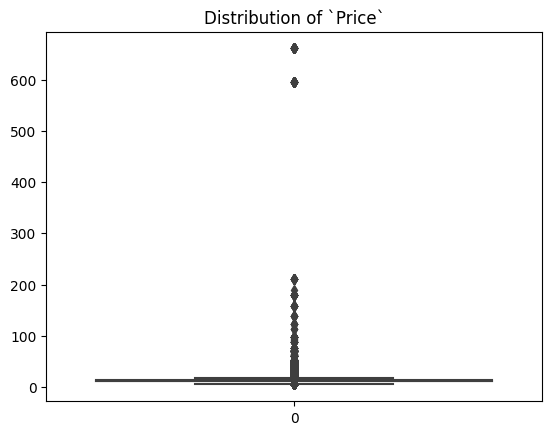

In [21]:
sns.boxplot(df['Price'])
plt.title("Distribution of `Price`")

The `Price` distribution is characterized 

<Axes: xlabel='Price', ylabel='Count'>

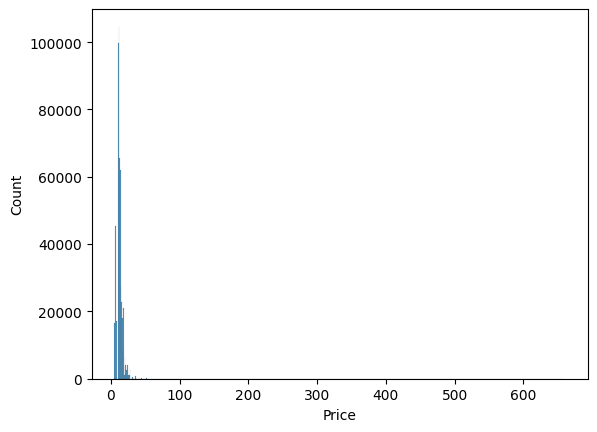

In [18]:
sns.histplot(df['Price'], binwidth=1)

We can see that the 

In [9]:
logs = np.log(df.select_dtypes([int, float]))
logs.columns = ['log'+c for c in logs.columns]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


<Axes: xlabel='logTotalPrice'>

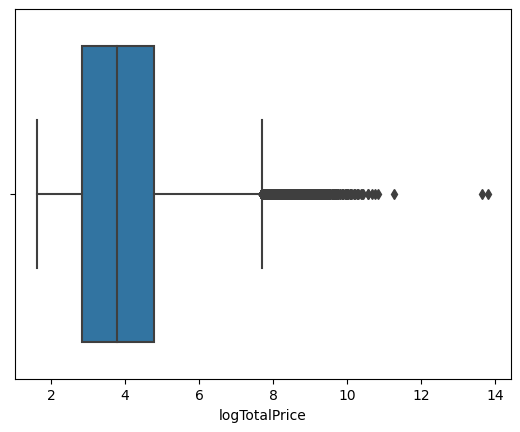

In [10]:
sns.boxplot(x=logs['logTotalPrice'])

<Axes: xlabel='logQuantity', ylabel='logTotalPrice'>

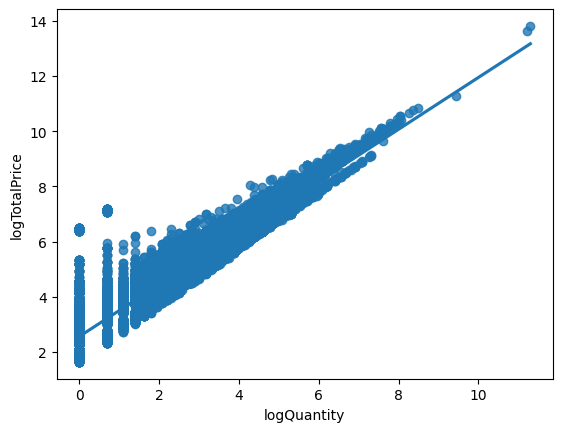

In [11]:
sns.regplot(logs, x='logQuantity', y='logTotalPrice')